In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [2]:
# 기본 Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, stride=1):
        super().__init__()
        out_channels = out_channels or in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(x)

        return self.relu(out + identity)

In [3]:
# 전체 Appearance CNN 정의
class DeepSortEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # Conv1
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),  # Conv2
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),       # MaxPool3

            ResidualBlock(32),  # Res4
            ResidualBlock(32),  # Res5

            ResidualBlock(32, 64, stride=2),  # Res6 (downsample)
            ResidualBlock(64),                # Res7

            ResidualBlock(64, 128, stride=2), # Res8 (downsample)
            ResidualBlock(128),               # Res9
        )

        self.embedding = nn.Sequential(
            nn.Flatten(),                    # flatten to (128×16×8) = 16384
            nn.Linear(128 * 16 * 8, 128),    # Dense 10
            nn.BatchNorm1d(128),
        )

    def forward(self, x):
        x = self.net(x)                    # CNN block
        x = self.embedding(x)             # FC layer
        x = F.normalize(x, p=2, dim=1)    # L2 normalization to unit hypersphere
        return x                          # shape: (N, 128)

In [4]:
def create_triplets(features, labels):
    anchors, positives, negatives = [], [], []

    labels = labels.cpu().numpy()
    for i in range(len(features)):
        a = features[i]
        label_a = labels[i]

        # Positive 샘플 선택
        pos_indices = np.where(labels == label_a)[0]
        pos_indices = pos_indices[pos_indices != i]
        if len(pos_indices) == 0: continue
        p = features[np.random.choice(pos_indices)]

        # Negative 샘플 선택
        neg_indices = np.where(labels != label_a)[0]
        n = features[np.random.choice(neg_indices)]

        anchors.append(a)
        positives.append(p)
        negatives.append(n)

    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)


In [5]:
data_dir = './data/processed/train/'
result_dir = './result/'
os.makedirs(result_dir, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu" 
epochs = 10  
print(f"Using Device: {device}")

# encoder 모델 정의
model = DeepSortEncoder().to(device)

transform = transforms.Compose([
    transforms.Resize((128, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
triplet_loss = nn.TripletMarginLoss(margin=0.3, p=2)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Using Device: cpu


In [6]:
epochs = 20
train_loss =[]

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        features = model(imgs)

        # Triplet 쌍 구성
        anchor, positive, negative = create_triplets(features, labels)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        loss = triplet_loss(anchor, positive, negative)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        batch_iterator.set_postfix(loss=loss.item())
        
    average_loss = total_loss / len(train_loader)
    train_loss.append(average_loss)
    print(f"[{epoch+1}/{epochs}] Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "deepsort_encoder.pth")

Epoch 1/20:   0%|          | 0/157 [00:41<?, ?batch/s, loss=0.0288] 

[1/20] Loss: 17.6244


Epoch 1/20:   0%|          | 0/157 [00:41<?, ?batch/s, loss=0.0288]


[2/20] Loss: 8.7621


Epoch 3/20:   0%|          | 0/157 [00:47<?, ?batch/s, loss=0]      

[3/20] Loss: 5.3482


Epoch 3/20:   0%|          | 0/157 [00:47<?, ?batch/s, loss=0]


[4/20] Loss: 3.4838


Epoch 5/20:   0%|          | 0/157 [00:51<?, ?batch/s, loss=0]       

[5/20] Loss: 2.9739


Epoch 5/20:   0%|          | 0/157 [00:51<?, ?batch/s, loss=0]


[6/20] Loss: 1.9571


Epoch 7/20:   0%|          | 0/157 [00:48<?, ?batch/s, loss=0]       

[7/20] Loss: 1.7310


Epoch 7/20:   0%|          | 0/157 [00:48<?, ?batch/s, loss=0]


[8/20] Loss: 1.1632


Epoch 9/20:   0%|          | 0/157 [00:46<?, ?batch/s, loss=0.0396]  

[9/20] Loss: 1.0891


Epoch 9/20:   0%|          | 0/157 [00:46<?, ?batch/s, loss=0.0396]


[10/20] Loss: 1.1797


Epoch 11/20:   0%|          | 0/157 [00:48<?, ?batch/s, loss=0]       

[11/20] Loss: 0.9493


Epoch 11/20:   0%|          | 0/157 [00:48<?, ?batch/s, loss=0]


[12/20] Loss: 1.1341


Epoch 13/20:   0%|          | 0/157 [00:56<?, ?batch/s, loss=0]       

[13/20] Loss: 0.7516


Epoch 13/20:   0%|          | 0/157 [00:56<?, ?batch/s, loss=0]


[14/20] Loss: 0.5788


Epoch 15/20:   0%|          | 0/157 [00:46<?, ?batch/s, loss=0]       

[15/20] Loss: 0.6587


Epoch 15/20:   0%|          | 0/157 [00:46<?, ?batch/s, loss=0]


[16/20] Loss: 0.6085


Epoch 17/20:   0%|          | 0/157 [00:50<?, ?batch/s, loss=0.0379]  

[17/20] Loss: 0.3006


Epoch 17/20:   0%|          | 0/157 [00:50<?, ?batch/s, loss=0.0379]


[18/20] Loss: 0.5599


Epoch 19/20:   0%|          | 0/157 [00:47<?, ?batch/s, loss=0.0363]  

[19/20] Loss: 0.7846


Epoch 19/20:   0%|          | 0/157 [00:47<?, ?batch/s, loss=0.0363]


[20/20] Loss: 0.7083


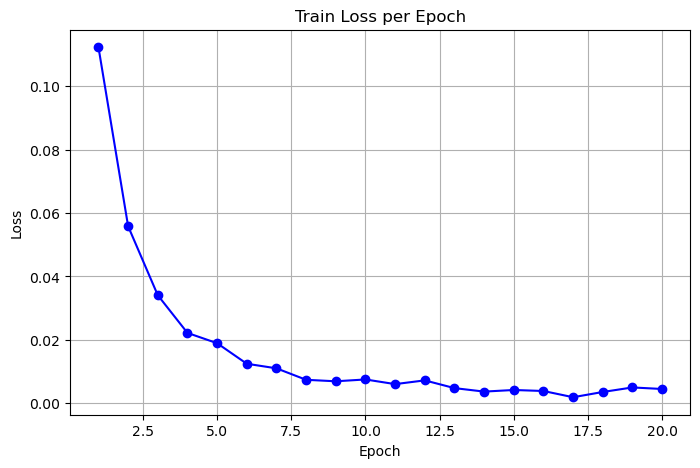

In [7]:
#  train loss 그래프 출력력
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), train_loss, marker='o', linestyle='-', color='b')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()